In [16]:
%load_ext autoreload
%autoreload 2
import sys
# this is where the sacrebleu is modified
# sacrebleu_path = '/nas/material02/users/tg/projects/beter-bleu/rebleu'
# if sacrebleu_path not in sys.path:
#     print(f'adding to sys.path: {sacrebleu_path}')
#     sys.path.insert(0, sacrebleu_path)

from sacrebleu import corpus_bleu
from sacrebleu.rebleu import corpus_rebleu
from sacrebleu.rebleu2 import corpus_rebleu2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# WMT System-Outputs, Refrences and Human Assessments

See setup.md file in this dir to get these files
Here they are!

In [17]:
! head -3 wmt/metrics-task/wmt*-metrics-task-package/manual-evaluation/DA-syslevel.csv

==> wmt/metrics-task/wmt17-metrics-task-package/manual-evaluation/DA-syslevel.csv <==
LP HUMAN SYSTEM
en-lv 0.196 tilde-nc-nmt-smt-hybrid.5047
en-lv 0.121 online-B.0

==> wmt/metrics-task/wmt18-metrics-task-package/manual-evaluation/DA-syslevel.csv <==
LP HUMAN SYSTEM
en-cs 0.594 CUNI-Transformer.5595
en-cs 0.384 uedin.5630

==> wmt/metrics-task/wmt19-metrics-task-package/manual-evaluation/DA-syslevel.csv <==
LP HUMAN SYSTEM
en-cs 0.402 CUNI-DocTransformer-T2T.6751
en-cs 0.401 CUNI-Transformer-T2T-2018.6457


In [18]:
!ls wmt/submissions/wmt1*-submitted-data/txt/
!ls wmt/submissions/wmt1*-submitted-data/txt/system-outputs/newstest201*/
!ls wmt/submissions/wmt19-submitted-data/txt/references/
!ls wmt/submissions/wmt19-submitted-data/txt/system-outputs/newstest2019/kk-en

wmt/submissions/wmt17-submitted-data/txt/:
references     sources        system-outputs

wmt/submissions/wmt18-submitted-data/txt/:
references     sources        system-outputs

wmt/submissions/wmt19-submitted-data/txt/:
references     sources        system-outputs
wmt/submissions/wmt17-submitted-data/txt/system-outputs/newstest2017/:
cs-en en-cs en-fi en-ru en-zh lv-en tr-en
de-en en-de en-lv en-tr fi-en ru-en zh-en

wmt/submissions/wmt18-submitted-data/txt/system-outputs/newstest2018/:
cs-en en-cs en-et en-ru en-zh fi-en tr-en
de-en en-de en-fi en-tr et-en ru-en zh-en

wmt/submissions/wmt19-submitted-data/txt/system-outputs/newstest2019/:
cs-de de-en en-cs en-fi en-kk en-ru fi-en gu-en lt-en zh-en
de-cs de-fr en-de en-gu en-lt en-zh fr-de kk-en ru-en
newstest2019-csde-ref.de newstest2019-engu-ref.gu newstest2019-guen-ref.en
newstest2019-decs-ref.cs newstest2019-enkk-ref.kk newstest2019-kken-ref.en
newstest2019-deen-ref.en newstest2019-enlt-ref.lt newstest2019-lten-ref.en
newstest2019

# Step1: Parse System Level Human Judgements

In [19]:
import collections as coll
from pathlib import Path
from dataclasses import dataclass, field

In [20]:
def read_human_scores(path):
    with path.open() as f:
        lines = [l.strip().split() for l in f]
    rows = lines[1:] # skip header

    mem = coll.defaultdict(dict)
    for lang_pair, score, name in rows:
        assert name not in mem[lang_pair]  # name is unique
        mem[lang_pair][name] = float(score)
    return dict(mem)

gold_sys = {}
WMTs = ['19', '18', '17']
for year in WMTs:
    wmt = f'wmt{year}'
    human_file = f'wmt/metrics-task/{wmt}-metrics-task-package/manual-evaluation/DA-syslevel.csv'
    human_scores = read_human_scores(Path(human_file))
    print(wmt, human_scores['de-en'])  # example
    gold_sys[wmt] = human_scores

wmt19 {'Facebook_FAIR.6750': 0.146, 'RWTH_Aachen_System.6818': 0.136, 'MSRA.MADL.6910': 0.136, 'online-B.0': 0.121, 'JHU.6809': 0.086, 'MLLP-UPV.6899': 0.067, 'dfki-nmt.6478': 0.066, 'UCAM.6461': 0.066, 'online-A.0': 0.05, 'NEU.6801': 0.039, 'uedin.6749': 0.011, 'online-Y.0': 0.009, 'TartuNLP-c.6502': 0.006, 'online-G.0': -0.051, 'PROMT_NMT_DE-EN.6683': -0.128, 'online-X.0': -0.192}
wmt18 {'RWTH.5636': 0.413, 'UCAM.5690': 0.395, 'NTT.5666': 0.359, 'online-B.0': 0.346, 'MLLP-UPV.5554': 0.321, 'JHU.5706': 0.317, 'Ubiqus-NMT.5635': 0.315, 'online-Y.0': 0.31, 'online-A.0': 0.268, 'uedin.5766': 0.261, 'LMU-nmt.5756': 0.162, 'NJUNMT-private.5406': 0.149, 'online-G.0': -0.074, 'online-F.0': -0.296, 'RWTH-UNSUPER.5482': -0.752, 'LMU-unsup.5650': -0.835}
wmt17 {'online-B.0': 0.213, 'online-A.0': 0.169, 'KIT.4951': 0.165, 'uedin-nmt.4723': 0.162, 'RWTH-nmt-ensemble.4920': 0.131, 'SYSTRAN.4846': 0.098, 'LIUM-NMT.4733': 0.029, 'TALP-UPC.4830': -0.058, 'online-G.0': -0.072, 'C-3MA.4958': -0.103, 'o

# Step 2: Load Sys-Out and Ref

Create a schema and load all to mem

In [21]:
from typing import List, Dict, Union
import logging as log
log.basicConfig(level=log.INFO)

@dataclass
class System:
    camp: str 
    lang: str
    name: str 
    out: Union[Path, List[str]]
    ref: Union[Path, List[str]]
    scores: Dict
    #parent: 'TransTask'        
    
@dataclass
class TransTask:
    camp: str
    name: str
    ref: Union[Path, List[str]]
    systs: Dict[str, System]
    #parent: 'Campaign'        

@dataclass
class Campaign:
    name: str
    root: Path
    langs: List
    tasks: Dict[str, TransTask]

def read_lines(path: Path):
    with path.open('r', encoding='utf-8', errors='ignore') as rdr:
        return list(line.strip() for line in rdr)

wmt_dir = Path('wmt')

camps = {}
for year in WMTs:
    name = f'wmt{year}'
    test = f'newstest20{year}'
    txt_dir = wmt_dir / f'submissions/{name}-submitted-data/txt/'
    camp = Campaign(name=name, root=txt_dir, tasks={}, langs=list(gold_sys[name].keys()))
    camps[name] = camp
    for lang in camp.langs:
        pair = lang.replace('-', '')
        tgt = lang.split('-')[-1]
        ref = camp.root / 'references' / f'{test}-{pair}-ref.{tgt}'
        assert ref.exists()
        ref = read_lines(ref)

        task = TransTask(name=lang, camp=camp.name, systs={}, ref=ref)
        camp.tasks[lang] = task
        for syst_name, human_score in gold_sys[camp.name][lang].items():
            out_path = camp.root / f'system-outputs/{test}/{lang}/{test}.{syst_name}.{lang}'
            if not out_path.exists():  # relocate file; looks like they did some mess; try mapping using sys_id integer
                syst_id = int(syst_name.split('.')[-1])
                remap = list(out_path.parent.glob(f'*.{syst_id}.{lang}'))
                if len(remap) == 1:
                    out_path = remap[0]
                    log.warning(f"fixing name: {syst_name} -> {out_path.name}")
                else:
                    log.warning(f'{out_path} not found. Skipping')
                    continue
            out = read_lines(out_path)
            syst = System(name=syst_name, lang=task.name, camp=camp.name, out=out, ref=ref,
                               scores=dict(human=human_score))
            task.systs[syst_name] = syst


# BLEU score


Tokenize all ahead of time and keep them in memory. 
this is efficient than tokenizing refs multiple times, once per each system.

In [22]:
from sacrebleu.tokenizer import tokenize_v14_international, tokenize_13a, tokenize_zh

def tokenize(lang, sents):
    assert isinstance(sents, list) and isinstance(sents[0], str)
    tokr = tokenize_13a

    if lang == 'zh':
        tokr = tokenize_zh
    return [tokr(sent) for sent in sents]
 
for camp in camps.values():
    for task in camp.tasks.values():
        print(f"{camp.name}\t{task.name}\t{len(task.ref)}\t{len(task.systs)}")
        lang = task.name.split('-')[-1]
        task.ref_tok = tokenize(lang, task.ref)
        
        for syst in task.systs.values():
            assert syst.ref is task.ref # same object; no duplicates
            assert len(syst.ref) == len(syst.out)
            syst.out_tok = tokenize(lang, syst.out)
            syst.ref_tok = task.ref_tok

wmt19	en-cs	1997	11
wmt19	en-gu	998	11
wmt19	en-lt	998	12
wmt19	de-cs	1997	11
wmt19	en-kk	998	11
wmt19	fi-en	1996	12
wmt19	zh-en	2000	15
wmt19	en-zh	1997	12
wmt19	fr-de	1701	10
wmt19	ru-en	2000	14
wmt19	kk-en	1000	11
wmt19	gu-en	1016	11
wmt19	lt-en	1000	11
wmt19	en-de	1997	22
wmt19	en-ru	1997	12
wmt19	en-fi	1997	12
wmt19	de-en	2000	16
wmt19	de-fr	1701	11
wmt18	en-cs	2983	5
wmt18	tr-en	3000	5
wmt18	fi-en	3000	9
wmt18	zh-en	3981	14
wmt18	en-zh	3981	14
wmt18	ru-en	3000	8
wmt18	en-de	2998	16
wmt18	en-ru	3000	9
wmt18	en-fi	3000	12
wmt18	et-en	2000	14
wmt18	en-et	2000	14
wmt18	en-tr	3000	8
wmt18	de-en	2998	16
wmt18	cs-en	2983	5
wmt17	en-lv	2001	17
wmt17	en-cs	3005	14
wmt17	tr-en	3007	10
wmt17	lv-en	2001	9
wmt17	fi-en	3002	6
wmt17	zh-en	2001	15
wmt17	en-zh	2001	11
wmt17	ru-en	3001	9
wmt17	en-de	3004	16
wmt17	en-ru	3001	9
wmt17	en-fi	3002	12
wmt17	en-tr	3007	8
wmt17	de-en	3004	11
wmt17	cs-en	3005	4


Verify that python API with ahead-of-time tokenization yields same scores as CLI which downloads refs itself and tokenizes on-the-fly.

In [23]:
%%bash
for lang in en-ru en-zh; do
    ls wmt/submissions/wmt18-submitted-data/txt/system-outputs/newstest2018/$lang/* \
    | head -2 | while read i; do
        echo -n "$lang $(basename $i) "
        cat $i| sacrebleu -m bleu -t wmt18 -l $lang -b
    done
done

en-ru newstest2018.Alibaba-ensemble-model.5713.en-ru 34.8
en-ru newstest2018.PROMT-Hybrid-Marian.5605.en-ru 27.3
en-zh newstest2018.Alibaba-General-System.5743.en-zh 43.1
en-zh newstest2018.Alibaba-General-System.5749.en-zh 43.2


sacreBLEU: Downloading http://data.statmt.org/wmt18/translation-task/test.tgz to /Users/weiqiuyou/.sacrebleu/wmt18/test.tgz
sacreBLEU: Checksum passed: f996c245ecffea23d0006fa4c34e9064
sacreBLEU: Extracting /Users/weiqiuyou/.sacrebleu/wmt18/test.tgz
sacreBLEU: Processing /Users/weiqiuyou/.sacrebleu/wmt18/raw/test/newstest2018-enru-src.en.sgm to /Users/weiqiuyou/.sacrebleu/wmt18/en-ru.en
sacreBLEU: Processing /Users/weiqiuyou/.sacrebleu/wmt18/raw/test/newstest2018-enru-ref.ru.sgm to /Users/weiqiuyou/.sacrebleu/wmt18/en-ru.ru
sacreBLEU: Processing /Users/weiqiuyou/.sacrebleu/wmt18/raw/test/newstest2018-enzh-src.en.sgm to /Users/weiqiuyou/.sacrebleu/wmt18/en-zh.en
sacreBLEU: Processing /Users/weiqiuyou/.sacrebleu/wmt18/raw/test/newstest2018-enzh-ref.zh.sgm to /Users/weiqiuyou/.sacrebleu/wmt18/en-zh.zh


In [24]:
select = [['en-ru', 'Alibaba-ensemble-model.5713', 'online-A.0'],
         ['en-zh', 'Alibaba-ensemble-system-with-reranking.5738', 'Alibaba-General-System.5743']]
for lang, *systs in select:
    for syst_name in systs:
        syst = camps['wmt18'].tasks[lang].systs[syst_name]
        score =  corpus_bleu(syst.out_tok, [syst.ref_tok], tokenize='none')
        print(lang, syst_name,  '%.1f' % score.score)

en-ru Alibaba-ensemble-model.5713 34.8
en-ru online-A.0 22.6
en-zh Alibaba-ensemble-system-with-reranking.5738 43.4
en-zh Alibaba-General-System.5743 43.1


In [30]:
from tqdm import tqdm
import multiprocessing as mp
import os
import csv
cpu_count = mp.cpu_count()
if 'SLURM_CPUS_ON_NODE' in os.environ:
    cpu_count = int(os.environ['SLURM_CPUS_ON_NODE'])
print('cpus', cpu_count)

def read_args():
    #for langs in gold_sys_scores.keys():
    for camp in camps.values():
        for task in camp.tasks.values():
            for syst in task.systs.values():
                yield syst

bleu_settings = dict(
    bleu    = dict(lowercase=False, use_effective_order=False),
    bleu_lc = dict(lowercase=True,  use_effective_order=False),
    bleu_eff_order = dict(lowercase=False, use_effective_order=True),
    bleu_eff_order_lc = dict(lowercase=True, use_effective_order=True)
)

rebleu_settings = dict(
    macro_1gF1    = dict(average='macro', max_order=1, lowercase=False),
    micro_1gF1    = dict(average='micro', max_order=1, lowercase=False),

    macro_1gF_2gP = dict(average='macro', max_order=2, lowercase=False),
    micro_1gF_2gP = dict(average='micro', max_order=2, lowercase=False),
    
    macro_1gF_3gP = dict(average='macro', max_order=3, lowercase=False),
    micro_1gF_3gP = dict(average='micro', max_order=3, lowercase=False),
    
    macro_1gF_4gP    = dict(average='macro', max_order=4, lowercase=False),   
    micro_1gF_4gP    = dict(average='micro', max_order=4, lowercase=False),
       
    macro_2gF = dict(average='macro', max_order=2, lowercase=False, measure_name='f1'),
    micro_2gF = dict(average='micro', max_order=2, lowercase=False, measure_name='f1'),
    
    macro_3gF = dict(average='macro', max_order=3, lowercase=False, measure_name='f1'),
    micro_3gF = dict(average='micro', max_order=3, lowercase=False, measure_name='f1'),
    
    macro_4gF    = dict(average='macro', max_order=4, lowercase=False, measure_name='f1'), 
    micro_4gF    = dict(average='micro', max_order=4, lowercase=False, measure_name='f1'),

    macro2_1gF_2gP = dict(average='macro', max_order=2, lowercase=False, word_class=True),
    micro2_1gF_2gP = dict(average='micro', max_order=2, lowercase=False, word_class=True),
    
    macro2_1gF_3gP = dict(average='macro', max_order=3, lowercase=False, word_class=True),
    micro2_1gF_3gP = dict(average='micro', max_order=3, lowercase=False, word_class=True),
    
    macro2_1gF_4gP    = dict(average='macro', max_order=4, lowercase=False, word_class=True),   
    micro2_1gF_4gP    = dict(average='micro', max_order=4, lowercase=False, word_class=True),
        
    macro2_2gF = dict(average='macro', max_order=2, lowercase=False, measure_name='f1', word_class=True),
    micro2_2gF = dict(average='micro', max_order=2, lowercase=False, measure_name='f1', word_class=True),
    
    macro2_3gF = dict(average='macro', max_order=3, lowercase=False, measure_name='f1', word_class=True),
    micro2_3gF = dict(average='micro', max_order=3, lowercase=False, measure_name='f1', word_class=True),
    
    macro2_4gF    = dict(average='macro', max_order=4, lowercase=False, measure_name='f1', word_class=True),    
    micro2_4gF    = dict(average='micro', max_order=4, lowercase=False, measure_name='f1', word_class=True),

)

def scoring_job(syst):
    tok_args = dict(force=True, tokenize='none')
    try:
        sys_tok = syst.out_tok
    except:
        return
    ref_tok = [syst.ref_tok]
    res = {}
    for name, params in bleu_settings.items():
        bleu = corpus_bleu(sys_tok, ref_tok, **params, **tok_args)
        res[name] = round(bleu.score, 3)   
    for name, params in rebleu_settings.items():
        rebleu = corpus_rebleu2(sys_tok, ref_tok, **params, **tok_args)
        res[name] = round(rebleu.score, 3)
    sys_id = syst.camp, syst.lang, syst.name
    return sys_id, res

# header and fields for output file
fieldnames = ['camp', 'lang', 'syst', 'human'] + list(bleu_settings.keys()) + list(rebleu_settings.keys())

def write_scores(systs, path):
    with open(path, 'w', encoding='utf8', newline='') as wrt:
        dwrt = csv.DictWriter(wrt, fieldnames=fieldnames, delimiter='\t')
        dwrt.writeheader()
        for syst in systs:
            row = dict(camp=syst.camp, lang=syst.lang, syst=syst.name)
            row.update(syst.scores)
            dwrt.writerow(row)

with mp.Pool(cpu_count) as pool:
    systs = list(read_args())
    #systs = list(read_args())[:10]    
    for res in tqdm(pool.imap(scoring_job, systs), total=len(systs)):
        (wmt_name, lang_name, syst_name), scores = res
        # scores updated back on the object of main process; all forks have copies that we dont need
        camps[wmt_name].tasks[lang_name].systs[syst_name].scores.update(scores)

    write_scores(systs, 'sample-scores-01.tsv')

print("Done")

cpus 16


100%|██████████| 525/525 [1:53:40<00:00, 12.99s/it]  


Done


--- 

# Correlations with Human Judgements

In [66]:
import pandas as pd

scores_file = 'sample-scores-01.tsv'
scores = pd.read_csv(scores_file, header=0, sep='\t')
scores

,camp,lang,syst,human,bleu,bleu_lc,bleu_eff_order,bleu_eff_order_lc,macro_1gF1,micro_1gF1,...,macro2_1gF_3gP,micro2_1gF_3gP,macro2_1gF_4gP,micro2_1gF_4gP,macro2_2gF,micro2_2gF,macro2_3gF,micro2_3gF,macro2_4gF,micro2_4gF
0,wmt19,en-cs,CUNI-DocTransformer-T2T.6751,0.402,29.936,30.439,29.936,30.439,32.758,51.956,...,26.653,40.805,20.105,31.649,39.213,60.688,30.370,49.518,23.558,40.352
1,wmt19,en-cs,CUNI-Transformer-T2T-2018.6457,0.401,29.855,30.315,29.855,30.315,32.463,51.856,...,25.971,40.677,19.649,31.691,38.295,60.400,29.560,49.262,23.026,40.329
2,wmt19,en-cs,CUNI-Transformer-T2T-2019.6851,0.388,29.390,29.915,29.390,29.915,31.825,51.211,...,25.825,40.277,19.355,31.164,38.101,60.023,29.470,48.948,22.748,39.829
3,wmt19,en-cs,CUNI-DocTransformer-Marian.6922,0.223,28.144,28.611,28.144,28.611,30.498,49.945,...,24.319,38.761,18.182,29.837,36.459,58.682,27.808,47.345,21.418,38.353
4,wmt19,en-cs,uedin.6667,0.206,27.890,28.348,27.890,28.348,31.545,50.687,...,24.646,39.133,18.140,29.859,37.163,59.316,28.143,47.640,21.324,38.249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,wmt17,de-en,online-F.0,-0.260,17.672,19.044,17.672,19.044,30.232,49.903,...,18.808,29.790,11.761,19.958,33.504,53.951,22.529,39.244,14.633,28.038
521,wmt17,cs-en,uedin-nmt.4955,0.181,30.948,31.863,30.948,31.863,39.357,58.341,...,30.765,42.345,23.131,33.278,45.605,63.747,35.968,53.189,28.019,44.207
522,wmt17,cs-en,online-B.0,0.068,27.448,28.366,27.448,28.366,36.519,55.913,...,26.992,39.272,19.747,30.121,41.885,61.414,31.750,49.909,24.083,40.563
523,wmt17,cs-en,online-A.0,-0.068,25.122,26.268,25.122,26.268,32.965,53.735,...,23.263,36.124,16.355,26.903,37.356,58.486,27.670,46.515,20.216,36.798


In [67]:
from tqdm import tqdm
tasks = []
other_keys = {'camp', 'lang', 'syst', 'human'}
metric_names = [k for k in scores.keys() if k not in other_keys]


def correlations(scores, method='pearson'):
    corrs = []
    groups = scores.groupby(['camp', 'lang']).size()
    for (camp, lang), n_systs in tqdm(groups.iteritems(), total=len(groups)):
        rows = scores[scores['camp'] == camp]
        rows = rows[rows['lang'] == lang]
        rec = dict(camp=camp, lang=lang, n_systs=n_systs)
        for name in metric_names:
            corr = rows['human'].corr(other=rows[name], method=method)
            rec[name] = round(corr, 3)
        corrs.append(rec)
    return pd.DataFrame(corrs)

correlations(scores, method='pearson').head()

100%|██████████| 46/46 [00:00<00:00, 119.50it/s]


,camp,lang,n_systs,bleu,bleu_lc,bleu_eff_order,bleu_eff_order_lc,macro_1gF1,micro_1gF1,macro_1gF_2gP,...,macro2_1gF_3gP,micro2_1gF_3gP,macro2_1gF_4gP,micro2_1gF_4gP,macro2_2gF,micro2_2gF,macro2_3gF,micro2_3gF,macro2_4gF,micro2_4gF
0,wmt17,cs-en,4,0.966,0.975,0.966,0.975,0.571,0.881,0.617,...,0.767,0.943,0.818,0.940,0.592,0.931,0.751,0.943,0.812,0.942
1,wmt17,de-en,11,0.929,0.928,0.929,0.928,0.963,0.947,0.961,...,0.935,0.904,0.934,0.904,0.940,0.905,0.934,0.899,0.932,0.899
2,wmt17,en-cs,14,0.954,0.956,0.954,0.956,0.956,0.961,0.951,...,0.933,0.938,0.938,0.941,0.932,0.940,0.933,0.940,0.939,0.943
3,wmt17,en-de,16,0.820,0.804,0.820,0.804,0.722,0.782,0.728,...,0.754,0.814,0.781,0.824,0.711,0.795,0.746,0.807,0.776,0.819
4,wmt17,en-fi,12,0.918,0.925,0.918,0.925,0.950,0.967,0.944,...,0.890,0.940,0.851,0.914,0.928,0.959,0.898,0.947,0.860,0.926


In [68]:
correlations(scores, method='spearman').head()

100%|██████████| 46/46 [00:00<00:00, 51.79it/s]


,camp,lang,n_systs,bleu,bleu_lc,bleu_eff_order,bleu_eff_order_lc,macro_1gF1,micro_1gF1,macro_1gF_2gP,...,macro2_1gF_3gP,micro2_1gF_3gP,macro2_1gF_4gP,micro2_1gF_4gP,macro2_2gF,micro2_2gF,macro2_3gF,micro2_3gF,macro2_4gF,micro2_4gF
0,wmt17,cs-en,4,1.000,1.000,1.000,1.000,0.800,0.800,0.800,...,0.800,1.000,0.800,1.000,0.800,1.000,0.800,1.000,0.800,1.000
1,wmt17,de-en,11,0.736,0.745,0.736,0.745,0.845,0.818,0.845,...,0.773,0.745,0.773,0.745,0.827,0.782,0.773,0.773,0.773,0.745
2,wmt17,en-cs,14,0.903,0.899,0.903,0.899,0.912,0.908,0.899,...,0.908,0.908,0.903,0.890,0.908,0.908,0.908,0.908,0.903,0.890
3,wmt17,en-de,16,0.850,0.850,0.850,0.850,0.618,0.635,0.618,...,0.682,0.809,0.688,0.868,0.621,0.709,0.662,0.818,0.697,0.850
4,wmt17,en-fi,12,0.853,0.853,0.853,0.853,0.902,0.888,0.811,...,0.874,0.867,0.846,0.874,0.895,0.867,0.874,0.867,0.874,0.874


In [69]:
p_corr = correlations(scores, method='pearson')
p_corr['id'] = p_corr['camp'] + ' ' + p_corr['lang']
p_corr = p_corr.set_index(keys=['id'])
p_corr= p_corr.drop(columns=['camp', 'lang', 'n_systs'])
p_corr.style.background_gradient(cmap='Blues')

100%|██████████| 46/46 [00:00<00:00, 124.10it/s]


,bleu,bleu_lc,bleu_eff_order,bleu_eff_order_lc,macro_1gF1,micro_1gF1,macro_1gF_2gP,micro_1gF_2gP,macro_1gF_3gP,micro_1gF_3gP,macro_1gF_4gP,micro_1gF_4gP,macro_2gF,micro_2gF,macro_3gF,micro_3gF,macro_4gF,micro_4gF,macro2_1gF_2gP,micro2_1gF_2gP,macro2_1gF_3gP,micro2_1gF_3gP,macro2_1gF_4gP,micro2_1gF_4gP,macro2_2gF,micro2_2gF,macro2_3gF,micro2_3gF,macro2_4gF,micro2_4gF
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
wmt17 cs-en,0.966000,0.975000,0.966000,0.975000,0.571000,0.881000,0.617000,0.868000,0.632000,0.869000,0.634000,0.870000,0.727000,0.888000,0.812000,0.905000,0.842000,0.908000,0.626000,0.938000,0.767000,0.943000,0.818000,0.940000,0.592000,0.931000,0.751000,0.943000,0.812000,0.942000
wmt17 de-en,0.929000,0.928000,0.929000,0.928000,0.963000,0.947000,0.961000,0.936000,0.958000,0.929000,0.955000,0.922000,0.957000,0.939000,0.949000,0.933000,0.944000,0.929000,0.941000,0.907000,0.935000,0.904000,0.934000,0.904000,0.940000,0.905000,0.934000,0.899000,0.932000,0.899000
wmt17 en-cs,0.954000,0.956000,0.954000,0.956000,0.956000,0.961000,0.951000,0.954000,0.949000,0.949000,0.948000,0.945000,0.946000,0.950000,0.942000,0.944000,0.941000,0.943000,0.932000,0.940000,0.933000,0.938000,0.938000,0.941000,0.932000,0.940000,0.933000,0.940000,0.939000,0.943000


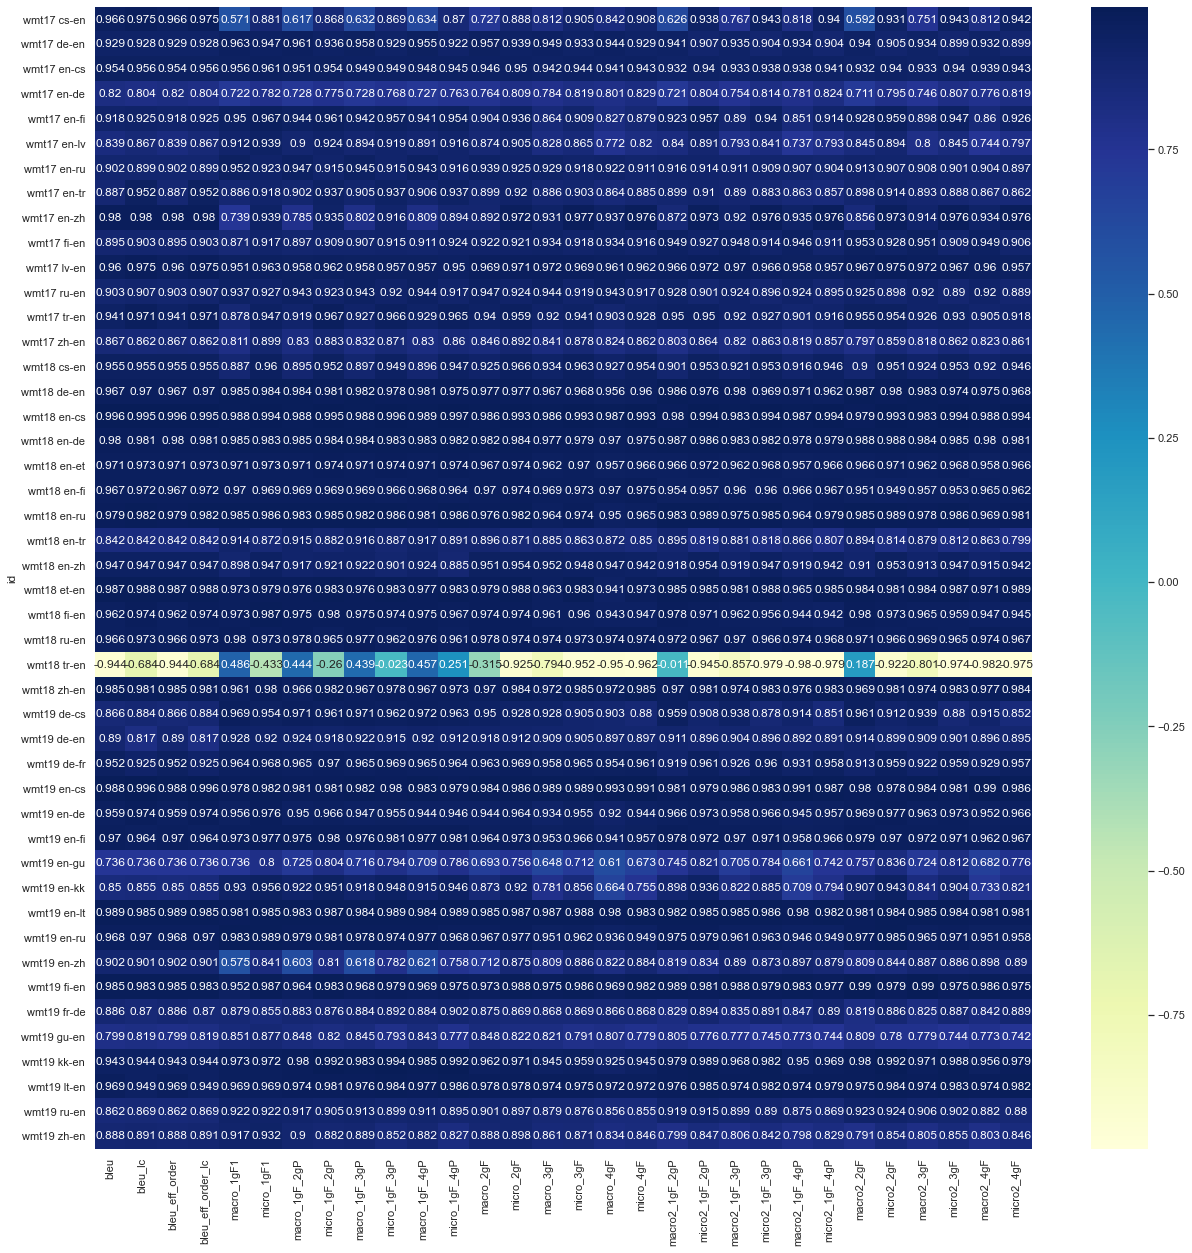

In [71]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(font="Times New Roman", style='white',font_scale=1)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(21, 21))
    ax = sns.heatmap(p_corr, annot=True, cmap="YlGnBu", fmt='.3g')

In [72]:
# all these have _lc in them
names = [k for k in p_corr.keys() if k + '_lc' in p_corr.keys()] 
print("How much improvement-or-damagae from caseless evaluation?")
print("Name        \tTotal\tMean\tMedian")
for name in names:
    diff = p_corr[name + '_lc'] - p_corr[name]
    print(f'{name:8}\t{diff.sum():.3f}\t{diff.mean():.3f}\t{diff.median():.3f}')

How much improvement-or-damagae from caseless evaluation?
Name        	Total	Mean	Median
bleu    	0.362	0.008	0.002
bleu_eff_order	0.362	0.008	0.002


> **Takeaway:  BLEU_lc is better than BLEU; but macro_1gm_F1 is better than its caseless equivalent**



- Get rid off all _lc cols; to reduce number of cols
- Get rid off bleu_eff_order as well; it is same as bleu

In [73]:
names = [k for k in p_corr.keys() if k + '_lc' in p_corr.keys()] 
drop_cols = ['bleu_eff_order'] + [ n + '_lc' for n in names]
p_corr = p_corr.drop(columns=drop_cols)
p_corr

,bleu,macro_1gF1,micro_1gF1,macro_1gF_2gP,micro_1gF_2gP,macro_1gF_3gP,micro_1gF_3gP,macro_1gF_4gP,micro_1gF_4gP,macro_2gF,...,macro2_1gF_3gP,micro2_1gF_3gP,macro2_1gF_4gP,micro2_1gF_4gP,macro2_2gF,micro2_2gF,macro2_3gF,micro2_3gF,macro2_4gF,micro2_4gF
id,,,,,,,,,,,,,,,,,,,,,
wmt17 cs-en,0.966,0.571,0.881,0.617,0.868,0.632,0.869,0.634,0.870,0.727,...,0.767,0.943,0.818,0.940,0.592,0.931,0.751,0.943,0.812,0.942
wmt17 de-en,0.929,0.963,0.947,0.961,0.936,0.958,0.929,0.955,0.922,0.957,...,0.935,0.904,0.934,0.904,0.940,0.905,0.934,0.899,0.932,0.899
wmt17 en-cs,0.954,0.956,0.961,0.951,0.954,0.949,0.949,0.948,0.945,0.946,...,0.933,0.938,0.938,0.941,0.932,0.940,0.933,0.940,0.939,0.943
wmt17 en-de,0.820,0.722,0.782,0.728,0.775,0.728,0.768,0.727,0.763,0.764,...,0.754,0.814,0.781,0.824,0.711,0.795,0.746,0.807,0.776,0.819
wmt17 en-fi,0.918,0.950,0.967,0.944,0.961,0.942,0.957,0.941,0.954,0.904,...,0.890,0.940,0.851,0.914,0.928,0.959,0.898,0.947,0.860,0.926
wmt17 en-lv,0.839,0.912,0.939,0.900,0.924,0.894,0.919,0.891,0.916,0.874,...,0.793,0.841,0.737,0.793,0.845,0.894,0.800,0.845,0.744,0.797
wmt17 en-ru,0.902,0.952,0.923,0.947,0.915,0.945,0.915,0.943,0.916,0.939,...,0.911,0.909,0.907,0.904,0.913,0.907,0.908,0.901,0.904,0.897
wmt17 en-tr,0.887,0.886,0.918,0.902,0.937,0.905,0.937,0.906,0.937,0.899,...,0.890,0.883,0.863,0.857,0.898,0.914,0.893,0.888,0.867,0.862
wmt17 en-zh,0.980,0.739,0.939,0.785,0.935,0.802,0.916,0.809,0.894,0.892,...,0.920,0.976,0.935,0.976,0.856,0.973,0.914,0.976,0.934,0.976


In [74]:
pd.DataFrame([p_corr.mean().to_dict(), p_corr.sum().to_dict()], index=['Mean', 'Sum']).round(3)

,bleu,macro_1gF1,micro_1gF1,macro_1gF_2gP,micro_1gF_2gP,macro_1gF_3gP,micro_1gF_3gP,macro_1gF_4gP,micro_1gF_4gP,macro_2gF,...,macro2_1gF_3gP,micro2_1gF_3gP,macro2_1gF_4gP,micro2_1gF_4gP,macro2_2gF,micro2_2gF,macro2_3gF,micro2_3gF,macro2_4gF,micro2_4gF
Mean,0.885,0.902,0.911,0.906,0.911,0.907,0.911,0.907,0.913,0.894,...,0.875,0.884,0.864,0.875,0.898,0.893,0.877,0.886,0.866,0.878
Sum,40.723,41.491,41.926,41.672,41.890,41.702,41.924,41.705,42.015,41.120,...,40.261,40.660,39.739,40.243,41.297,41.085,40.359,40.752,39.850,40.383


Color map values: 
Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r

saving to viz/wmt17-pearson.pdf
saving to viz/wmt18-pearson.pdf
saving to viz/wmt19-pearson.pdf


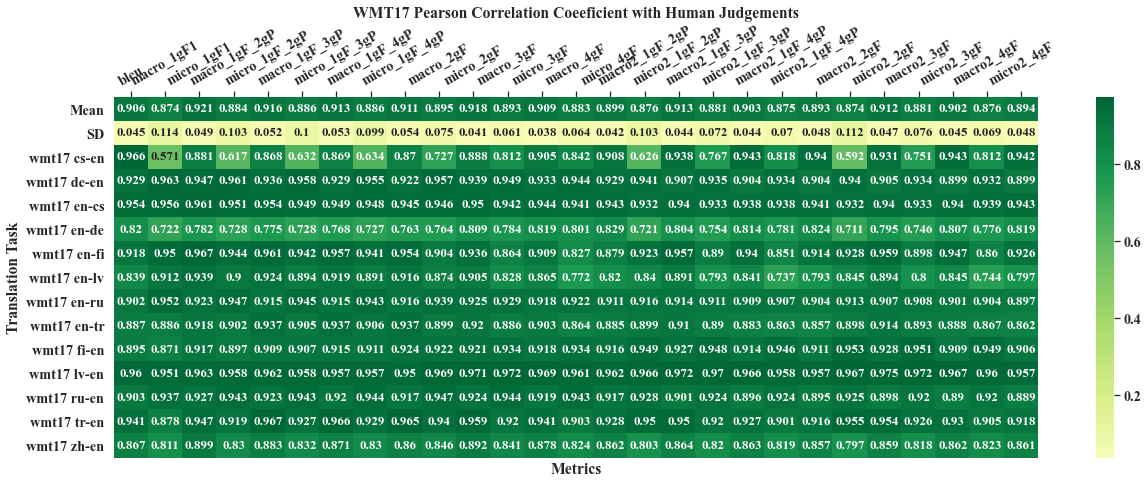

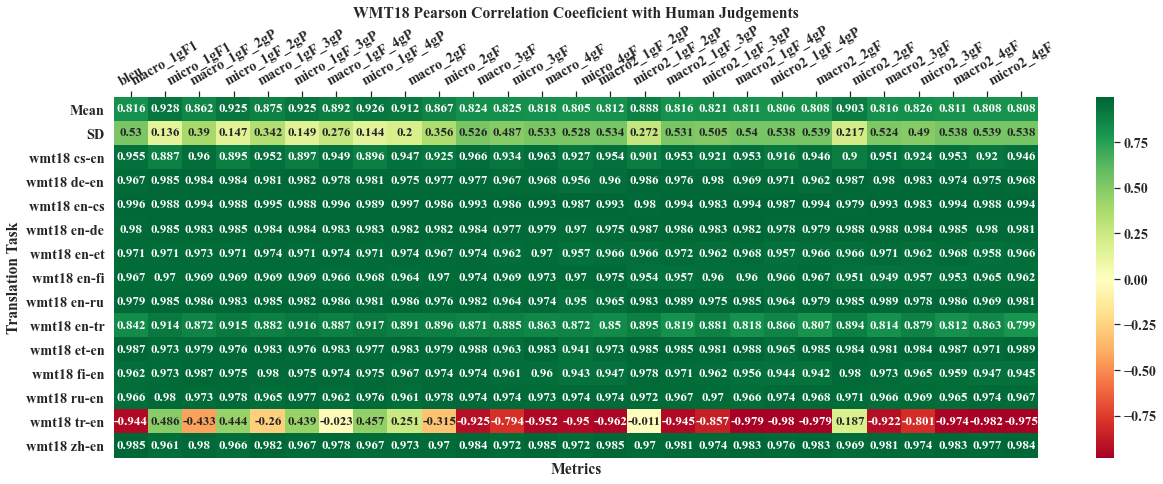

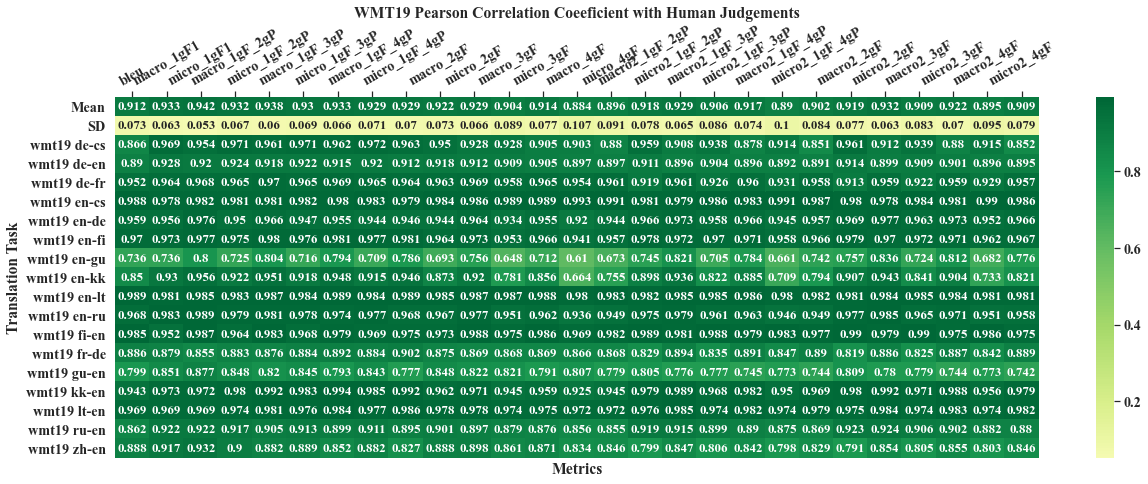

In [75]:
def plot_heatmap(df, figsize=(18, 7), title=None, xlabel='Metrics',
                 ylabel='Translation Task', partition=True,
                 add_sum=False,  add_mean=False, add_sd=False,
                 center=0, fmt='.3g', annot=True, cmap='RdYlGn', saveto=None):

    if partition:
        dfs = []        
        for year in ['wmt17', 'wmt18', 'wmt19']:
            part = df[df.index.to_series().apply(lambda x: year in x)]
            part_saveto = None            
            if saveto:
                basename = year + '-' + saveto.split('/')[-1]
                part_saveto = '/'.join(saveto.split('/')[:-1] + [basename])
            dfs.append((year.upper() + ' ' + title, part_saveto, part))
    else:
        dfs = [title, saveto, df]

    sns.set(font="Times New Roman", style='white',font_scale=1.3, palette=sns.color_palette())
    for title, saveto,  df in dfs:
        
        extra = []
        if add_sum:
            extra.append(['Total', df.sum().to_dict()])
        if add_mean:
            extra.append(['Mean', df.mean().to_dict()])
        if add_sd:
            extra.append(['SD', df.std().to_dict()])
        if extra:
            extra = pd.DataFrame([d for t, d,  in extra], index = [t for t, d in extra]).round(3)
            df = pd.concat([extra, df])

        f, ax = plt.subplots(figsize=figsize)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        annot_kws = {"size": 13}
        g = sns.heatmap(df, annot=annot, fmt=fmt, center=center, cmap=cmap, annot_kws=annot_kws)
        plt.xticks(rotation=30)    
        if title:
            plt.title(title)
        if xlabel:
            plt.xlabel(xlabel)
        if ylabel:
            plt.ylabel(ylabel)
        plt.tight_layout()
        if saveto:
            print(f'saving to {saveto}')
            plt.savefig(saveto)

p_corr_no_zh = p_corr[p_corr.index.to_series().apply(lambda x: '-zh' not in x)]
plot_heatmap(p_corr_no_zh, title='Pearson Correlation Coeeficient with Human Judgements',
             add_mean=True, add_sd=True, saveto='viz/pearson.pdf')
#'

saving to viz/wmt17-pearson-diff.pdf
saving to viz/wmt18-pearson-diff.pdf
saving to viz/wmt19-pearson-diff.pdf


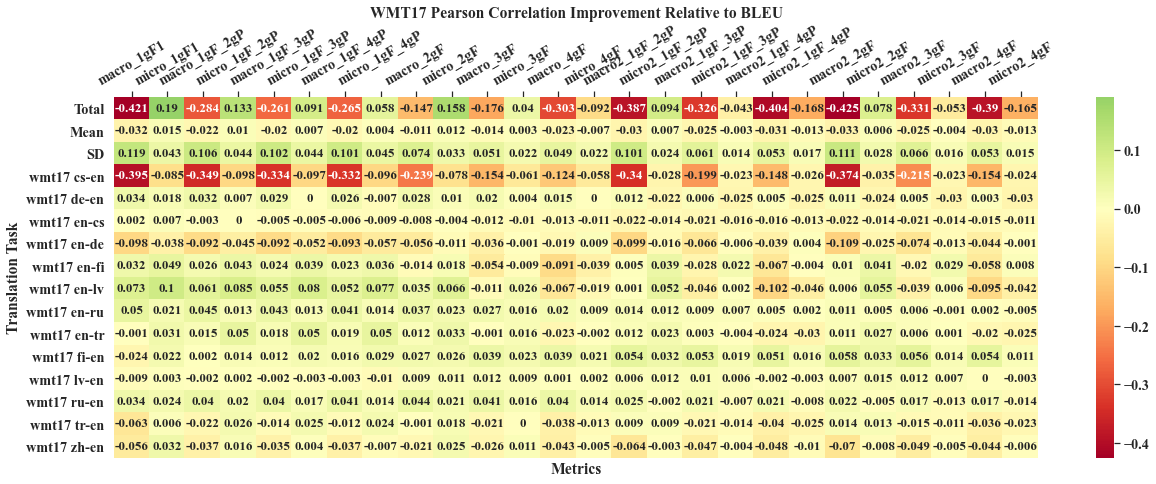

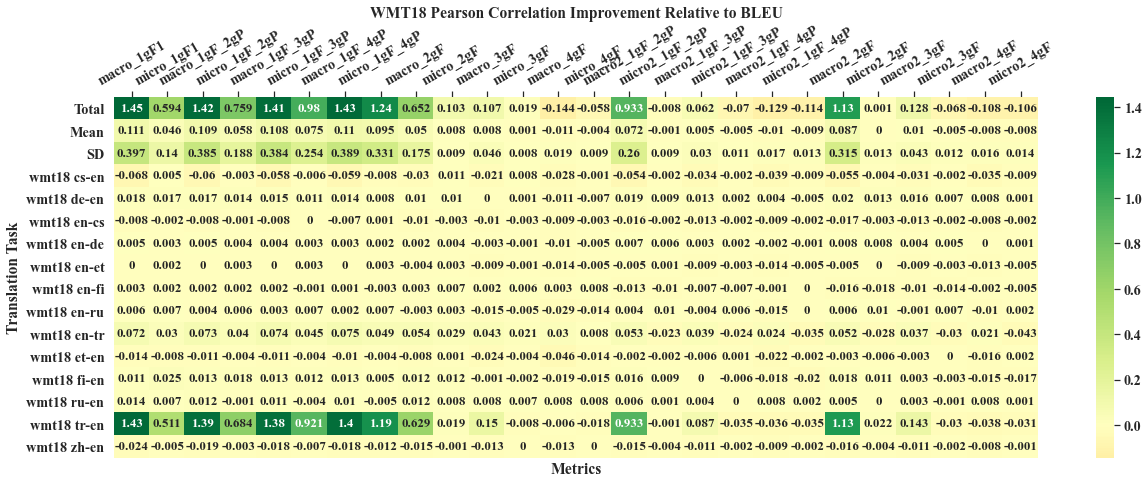

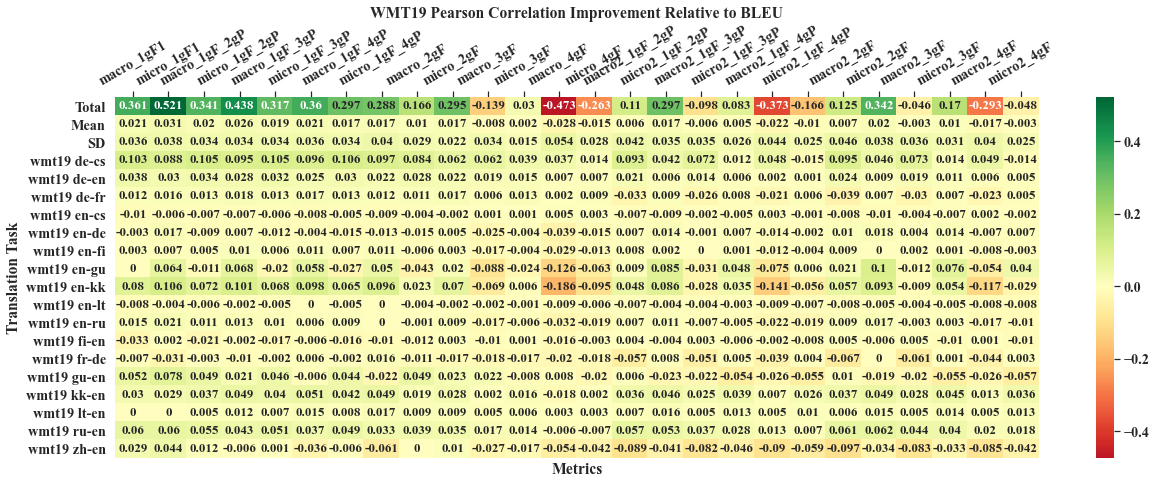

In [76]:
# relative to BLEU

diff = p_corr.copy()
names = [k for k in p_corr.keys() if k != 'bleu']
for name in names:
    diff[name] -= diff['bleu']
diff = diff.drop(columns=['bleu'])


#plot_heatmap(diff, title="Relative Improvement in Pearson Correlation wrt BLEU", 
#             add_mean=True, add_sd=True, add_sum=True)

#chinese is weird!
diff_no_zh = diff[diff.index.to_series().apply(lambda x: '-zh' not in x)]
plot_heatmap(diff_no_zh, title="Pearson Correlation Improvement Relative to BLEU",
             add_mean=True, add_sd=True, add_sum=True, saveto='viz/pearson-diff.pdf')

# Spearman

100%|██████████| 46/46 [00:01<00:00, 45.28it/s]


saving to viz/wmt17-spearman.pdf
saving to viz/wmt18-spearman.pdf
saving to viz/wmt19-spearman.pdf
saving to viz/wmt17-spearman-diff.pdf
saving to viz/wmt18-spearman-diff.pdf
saving to viz/wmt19-spearman-diff.pdf


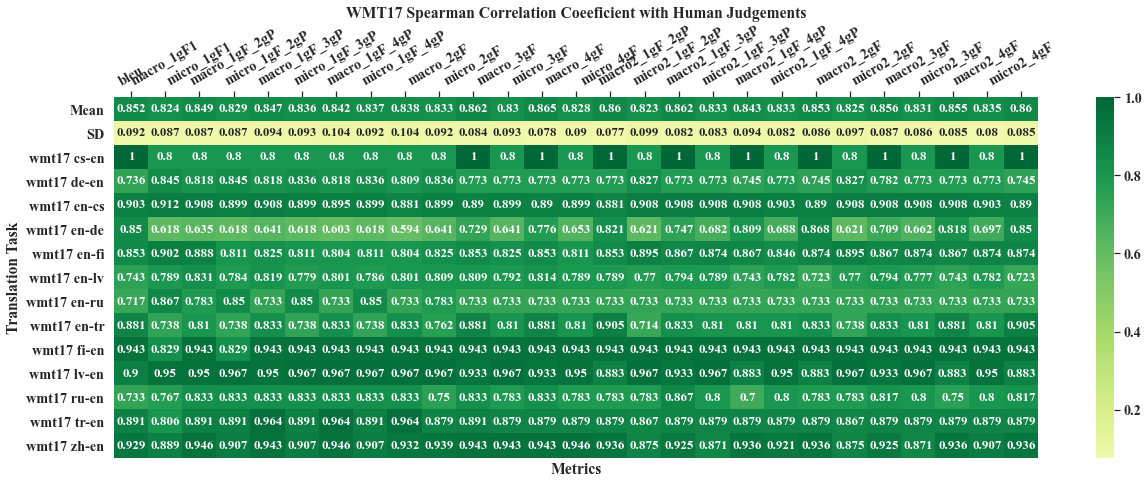

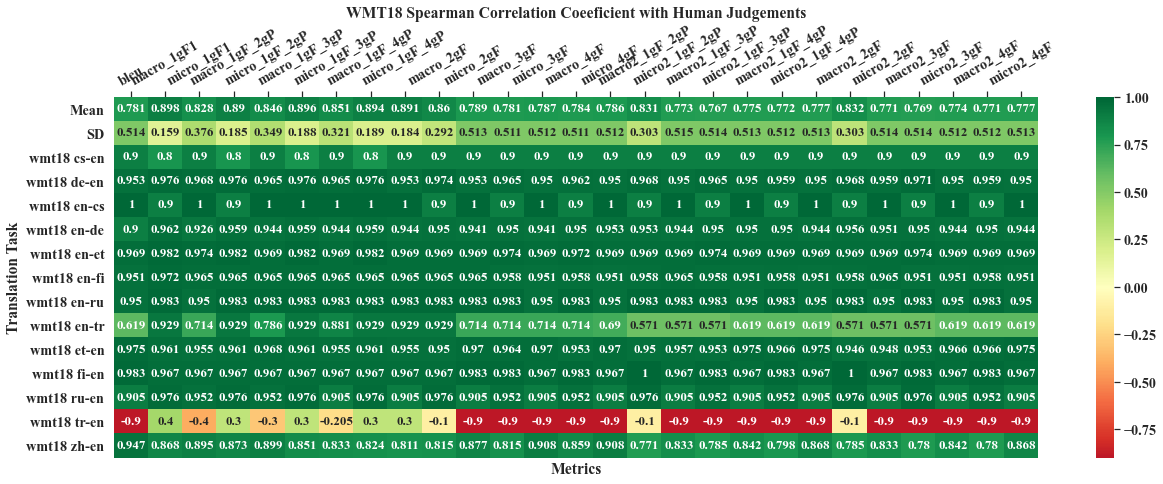

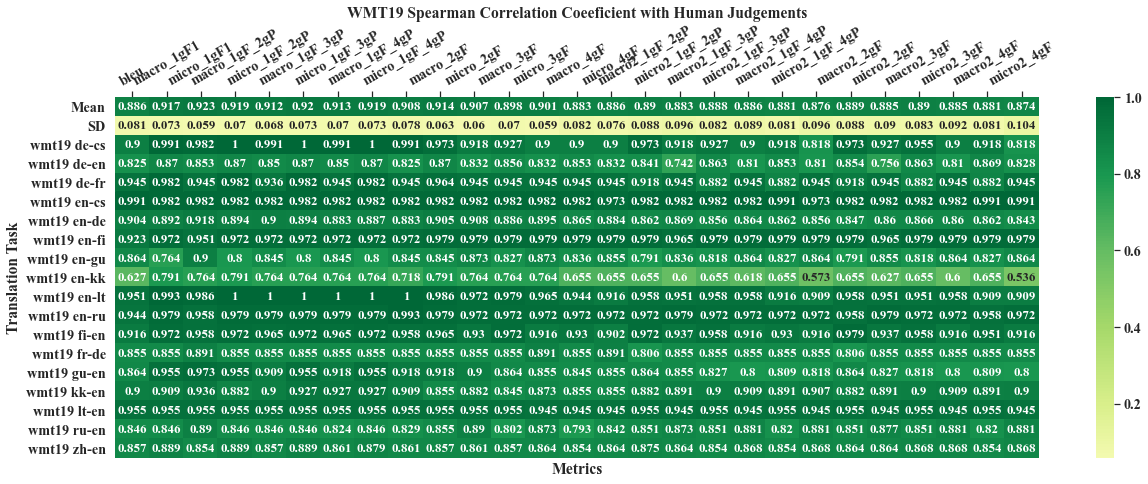

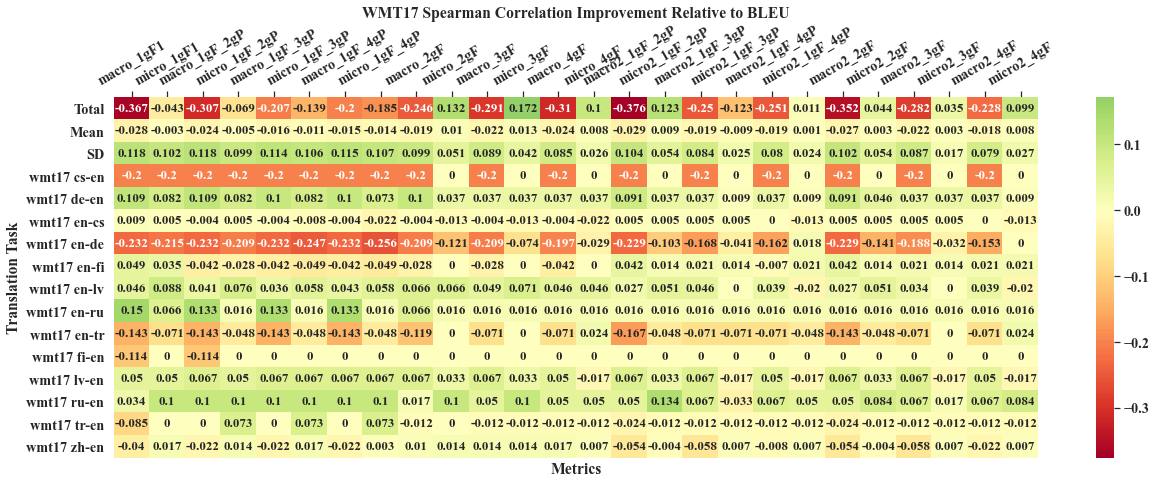

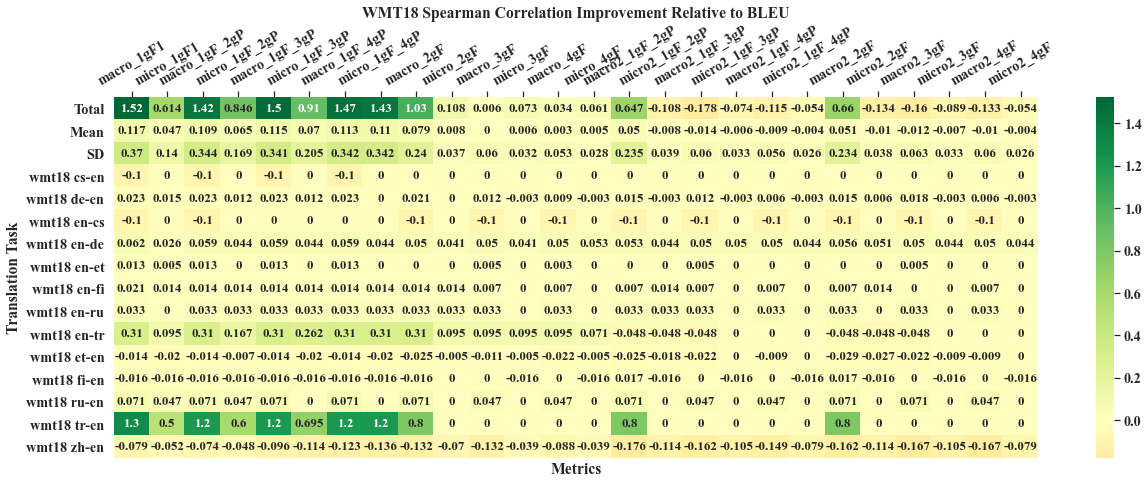

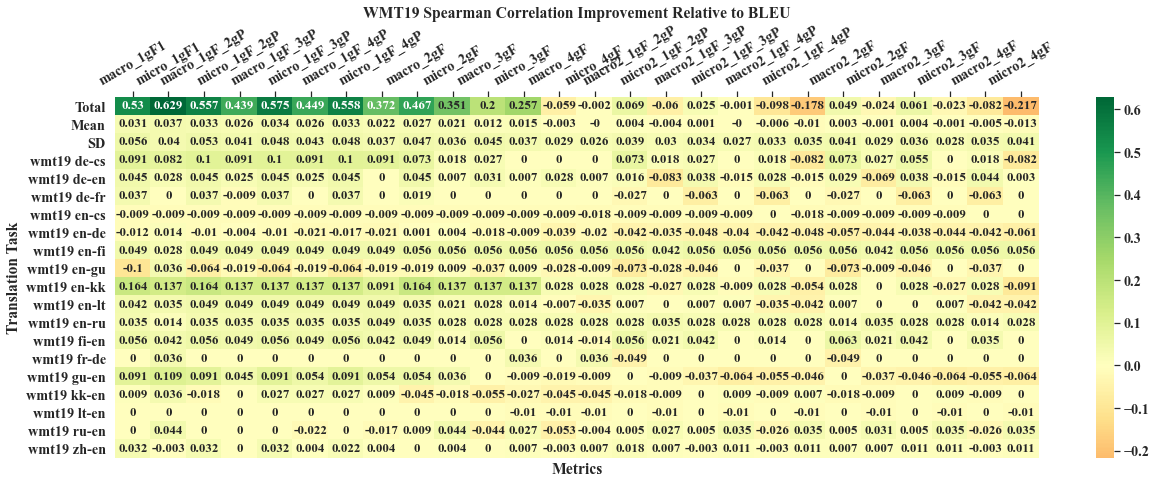

In [77]:
s_corr = correlations(scores, method='spearman')
s_corr['id'] = s_corr['camp'] + ' ' + s_corr['lang']
s_corr = s_corr.set_index(keys=['id'])
s_corr= s_corr.drop(columns=['camp', 'lang', 'n_systs'])

names = [k for k in s_corr.keys() if k + '_lc' in s_corr.keys()] 
drop_cols = ['bleu_eff_order'] + [ n + '_lc' for n in names]
s_corr = s_corr.drop(columns=drop_cols)

s_corr_no_zh = s_corr[s_corr.index.to_series().apply(lambda x: '-zh' not in x)]
plot_heatmap(s_corr_no_zh, title='Spearman Correlation Coeeficient with Human Judgements',
            add_mean=True, add_sd=True, saveto='viz/spearman.pdf')

s_diff = s_corr.copy()
names = [k for k in s_corr.keys() if k != 'bleu']
for name in names:
    s_diff[name] -= s_diff['bleu']
s_diff = s_diff.drop(columns=['bleu'])

s_diff_no_zh = s_diff[s_diff.index.to_series().apply(lambda x: '-zh' not in x)]
plot_heatmap(s_diff_no_zh, title='Spearman Correlation Improvement Relative to BLEU',
            add_sum=True, add_mean=True, add_sd=True, saveto='viz/spearman-diff.pdf')

---
---

# Visualize BLEU damage


This visualization shows weightage towards low frequency

In [58]:
from typing import List, Set
import re
import collections as coll
from pathlib import Path
import sacrebleu
from sacrebleu import corpus_bleu, TOKENIZERS, corpus_rebleu2
from tqdm import tqdm

import logging as log
log.basicConfig(level=log.INFO)

In [59]:
def replace_one_word(word:str, lines: List[str], repl=''):
    assert isinstance(lines, list)
    assert isinstance(word, str)
    res = []
    space_patt = re.compile(r' +')
    for line in lines:
        if word in line:
            line = ' '.join(repl if tok == word else tok for tok in line.split())
            line = space_patt.sub(' ', line).strip()
        res.append(line)
    return res

replace_one_word('the', ['the cat sat on the lazy mat'], repl='')

['cat sat on lazy mat']

In [60]:
!ls wmt/submissions/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en

wmt/submissions/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en


In [61]:

def read_lines(path):
    with path.open(encoding='utf8', errors='ignore') as f:
        return [line.strip() for line in f]
    
deen_ref = Path('wmt/submissions/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en')
tokenizer = TOKENIZERS['13a']

lines = [tokenizer(line.lower()) for line in read_lines(deen_ref)]
log.info(f'{len(lines)} lines in {deen_ref}')
sys = lines
refs = [lines]


def term_frequencies(lines):
    toks = (t for l in lines for t in l.split())
    stats = coll.Counter(toks)
    stats = sorted(stats.items(), reverse=True, key=lambda x: x[1])
    return stats

tfreqs = term_frequencies(lines)
tfreqs[:5], tfreqs[-5:], '\n', len(tfreqs)

INFO:root:2000 lines in wmt/submissions/wmt19-submitted-data/txt/references/newstest2019-deen-ref.en


([('the', 3012), ('.', 1902), (',', 1592), ('of', 849), ('in', 827)],
 [('extra-time', 1),
  ('christopher', 1),
  ('nkunku', 1),
  ('groundbreaking', 1),
  ('belgrade', 1)],
 '\n',
 6933)

In [62]:
import multiprocessing as mp
import os
cpu_count = mp.cpu_count()
if 'SLURM_CPUS_ON_NODE' in os.environ:
    cpu_count = int(os.environ['SLURM_CPUS_ON_NODE'])
print('cpus', cpu_count)

def compute_bleu(args):
    word, freq = args
    sys = replace_one_word(word, lines, repl='')
    bleu = corpus_bleu(sys, refs, force=True)
    macro_rebleu = corpus_rebleu2(sys, refs, force=True, average='macro', smooth_value=0,  max_order=4)
    micro_rebleu = corpus_rebleu2(sys, refs, force=True, average='micro', smooth_value=0, max_order=4)
    macro_rebleu2 = corpus_rebleu2(sys, refs, force=True, average='macro', smooth_value=0,  max_order=4, word_class=True)
    micro_rebleu2 = corpus_rebleu2(sys, refs, force=True, average='micro', smooth_value=0, max_order=4, word_class=True)
    return [word, freq, bleu.score, macro_rebleu.score, micro_rebleu.score, macro_rebleu2.score, micro_rebleu2.score]

points = []
with mp.Pool(cpu_count) as pool:

    data = tfreqs[-50:]
    n = len(data)    
    for stat in tqdm(pool.imap(compute_bleu, data), total=n):
        points.append(stat)

cpus 16


100%|██████████| 50/50 [01:37<00:00,  1.95s/it]


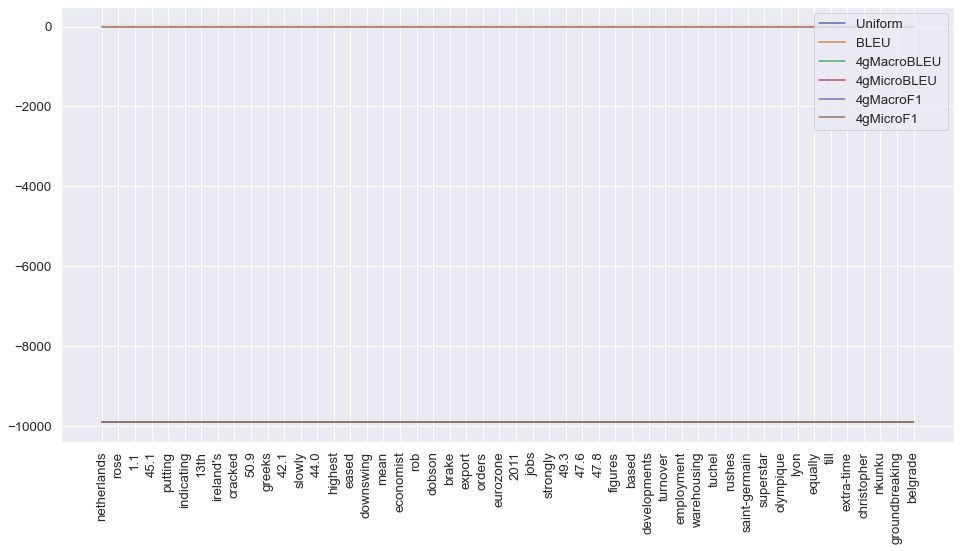

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histogram(x, ys, yscale='log', save=None):
    
    fig = plt.figure(figsize=(16, 8),)
    fig.tight_layout()
    for name, y in ys:
        plt.plot(x, y, label=name)

    plt.xticks(rotation=90) 
    plt.yscale(yscale)
    plt.legend(loc='upper right')
    if save:
        log.info(f'Saving to {save}')
        plt.savefig(save)
    plt.show()
    

pts = points
x = [pt[0] for pt in pts]
uniform = [1/len(tfreqs)] * len(pts)
freqs = [pt[1] for pt in pts]
bleu = [100 - pt[2] for pt in pts]
macro_rebleu = [100 *(1 - pt[3]) for pt in pts]
micro_rebleu = [100 *(1 - pt[4]) for pt in pts]
macro_rebleu2 = [100 *(1 - pt[5]) for pt in pts]
micro_rebleu2 = [100 *(1 - pt[6]) for pt in pts]


sns.set(font_scale=1.2)
ys = [
      ('Uniform', uniform),
      ('BLEU', bleu),
      ('4gMacroBLEU', macro_rebleu),
      ('4gMicroBLEU', micro_rebleu),
      ('4gMacroF1', macro_rebleu2),
      ('4gMicroF1', micro_rebleu2),
     ]
# save='bleu-vs-rebleu-viz'
plot_histogram(x, ys, yscale='linear')